# Практика №4

Теперь мы построим и обучим простую end-to-end модель. Будем работать с пропатченной версией уже готового [пайплайна](https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch). Также нам пригодится [ESPnet](https://github.com/espnet/espnet) для использования модели [Transformer](http://jalammar.github.io/illustrated-transformer/) в качестве энкодера.

### Bootstrap

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri May  7 23:31:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install torchaudio

     |████████████████████████████████| 1.9MB 15.6MB/s 


In [3]:
!gdown --id '1skrVbNyrhBLeceGS9CV9uIw_gvo1JiA6'

!unzip -q lab4.zip
!rm -rf lab4.zip sample_data
%cd lab4

Downloading...
From: https://drive.google.com/uc?id=1skrVbNyrhBLeceGS9CV9uIw_gvo1JiA6
To: /content/lab4.zip
2.77MB [00:00, 86.6MB/s]
/content/lab4


In [4]:
import os
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np
import math

from utils import TextTransform
from utils import cer
from utils import wer

from espnet.nets.pytorch_backend.transformer.embedding import PositionalEncoding
# from espnet.nets.pytorch_backend.transformer.encoder_layer import EncoderLayer #For initial model
from espnet.nets.pytorch_backend.transformer.repeat import repeat
from espnet.nets.pytorch_backend.transformer.attention import MultiHeadedAttention
from espnet.nets.pytorch_backend.transformer.positionwise_feed_forward import PositionwiseFeedForward
from espnet.nets.pytorch_backend.transformer.layer_norm import LayerNorm
from espnet.nets.pytorch_backend.nets_utils import make_pad_mask

In [5]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
train_audio_transforms = torch.nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=400, hop_length=160, n_mels=80),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram(sample_rate=16000,
                                                              n_fft=400,
                                                              hop_length=160,
                                                              n_mels=80)

# text_transform = TextTransform() #for baseline Transformer model

#-----------------------------TODO №2-----------------------------------
# Заменить графемный токенайзер на сабвордовый TextTransformBPE
text_transform = TextTransformBPE('/content/lab4/train_clean_100_text_clean.txt')
#-----------------------------------------------------------------------


def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        elif data_type == 'valid':
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            raise Exception('data_type should be train or valid')
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0])
        label_lengths.append(len(label))

    spectrograms = torch.nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths


def GreedyDecoder(output, labels, label_lengths, blank_label=4000, collapse_repeated=True): #blank_label=28 for baseline Transformer model with TextTransform()
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

In [ ]:
class TransformerModel(torch.nn.Module):

    def __init__(
        self,
        input_size=80,
        output_size=29,
        conv2d_filters=32,
        attention_dim=360,
        attention_heads=8,
        feedforward_dim=1024,
        num_layers=10,
        dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        
        self.conv_in = torch.nn.Sequential(
            torch.nn.Conv2d(1, conv2d_filters, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(conv2d_filters, conv2d_filters, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
            torch.nn.ReLU(),
        )
        self.conv_out = torch.nn.Sequential(
            torch.nn.Linear(conv2d_filters * ((input_size // 2) // 2), attention_dim),
            PositionalEncoding(attention_dim, 0.1),
        )
        positionwise_layer = PositionwiseFeedForward
        positionwise_layer_args = (attention_dim, feedforward_dim, dropout)
        self.encoder_layer = repeat(
            num_layers,
            lambda lnum: EncoderLayer(
                attention_dim,
                MultiHeadedAttention(
                    attention_heads, attention_dim, dropout
                ),
                positionwise_layer(*positionwise_layer_args),
                dropout,
                normalize_before=True,
                concat_after=False,
            ),
        )
        self.after_norm = LayerNorm(attention_dim)
        self.final_layer = torch.nn.Linear(attention_dim, output_size)

    def forward(self, x, ilens):
        x = x.unsqueeze(1)  # (b, c, t, f)
        x = self.conv_in(x)
        b, c, t, f = x.size()
        x = self.conv_out(x.transpose(1, 2).contiguous().view(b, t, c * f))
        masks = (~make_pad_mask(ilens)[:, None, :])[:, :, ::4].to(x.device)
        x, _ = self.encoder_layer(x, masks)
        x = self.after_norm(x)
        x = self.final_layer(x)
        return x

In [18]:
def train(model, device, train_loader, criterion, optimizer, scheduler, epoch):
    model.train()
    data_len = len(train_loader.dataset)

    train_loss = []

    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data 
        spectrograms, labels = spectrograms[:, :, :,:max(input_lengths)].to(device), labels.to(device) #(batch, 1, feat_dim, time)
        spectrograms = spectrograms.squeeze(1).transpose(1,2) # (batch, time, feat_dim,)
        optimizer.zero_grad()
        
        output = model(spectrograms, input_lengths)  # (batch, time, n_classes)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)
        input_lengths = [x // 4 for x in input_lengths]

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()
        
        train_loss.append(loss.item())

        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        scheduler.step()
        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLR: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                100. * batch_idx / len(train_loader), loss.item(), scheduler.get_last_lr()[0]))
            
    return np.mean(train_loss)


def test(model, device, test_loader, criterion, epoch):
    print('\nevaluating...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            spectrograms = spectrograms.squeeze(1).transpose(1,2) # (batch time, feat_dim,)
            
            output = model(spectrograms, input_lengths)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)
            input_lengths = [x // 4 for x in input_lengths]

            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)

    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))
    return test_loss

In [39]:
def main(learning_rate=1e-5, batch_size=20, test_batch_size=7, epochs=10,
        train_url="train-clean-100", test_url="test-clean"):
    
    hparams = {
        "input_size": 80,
        "output_size": 4001, #"output_size": 29 for baseline Transformer model with TextTransform() 
        "conv2d_filters": 32,
        "attention_dim": 360,
        "attention_heads": 8,
        "feedforward_dim": 1024,
        "num_blocks":10,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }

    use_cuda = torch.cuda.is_available()
    torch.manual_seed(7)
    device = torch.device("cuda" if use_cuda else "cpu")

    if not os.path.isdir("./data"):
        os.makedirs("./data")

    train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=train_url, download=True)
    test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=test_url, download=True)

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=hparams['batch_size'],
                                shuffle=True,
                                collate_fn=lambda x: data_processing(x, 'train'),
                                **kwargs)
    test_loader = data.DataLoader(dataset=test_dataset,
                                batch_size=test_batch_size,
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x, 'valid'),
                                **kwargs)
    

# # -----BASELINE MODEL--------------------
#     model = TransformerModel(
#         hparams['input_size'],
#         hparams['output_size'],
#         hparams['conv2d_filters'],
#         hparams['attention_dim'],
#         hparams['attention_heads'],
#         hparams['feedforward_dim'],
#         hparams['num_layers'],
#         hparams['dropout']).to(device)
# # -----------------------------------------

    
    model = ConformerModel(
        hparams['input_size'],
        hparams['output_size'],
        hparams['conv2d_filters'],
        hparams['attention_dim'],
        hparams['attention_heads'],
        hparams['feedforward_dim'],
        hparams['num_blocks'],
        hparams['dropout']).to(device)   

    print(model)
    print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

    optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
    criterion = torch.nn.CTCLoss(blank=4000, zero_infinity=False).to(device) # blank=28 for init model with TextTransform()

    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], 
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=hparams['epochs'],
                                            anneal_strategy='linear')
    
    train_history = []
    val_history = []
    for epoch in range(1, epochs + 1):
        !date
        train_loss = train(model, device, train_loader, criterion, optimizer, scheduler, epoch)
        val_loss = test(model, device, test_loader, criterion, epoch)

        train_history.append(train_loss)
        val_history.append(val_loss)

        with open(os.path.join("runs", "ep{}_checkpoint.pth".format(epoch)), "wb") as fp:
          torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'train_history': train_history,
            'valid_history': val_history,   
            }, fp)
    return train_history, val_history

In [40]:
learning_rate = 1e-3
batch_size = 10
test_batch_size = 7
epochs = 10
libri_train_set = "train-clean-100"
libri_test_set = "test-clean"

os.makedirs("runs", exist_ok=True)

train_history, val_history = main(learning_rate, batch_size, test_batch_size, epochs, libri_train_set, libri_test_set)

ConformerModel(
  (conv_in): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (conv_out): Sequential(
    (0): Linear(in_features=640, out_features=360, bias=True)
    (1): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (encoder_layer): MultiSequential(
    (0): EncoderLayer(
      (self_attn): MultiHeadedAttention(
        (linear_q): Linear(in_features=360, out_features=360, bias=True)
        (linear_k): Linear(in_features=360, out_features=360, bias=True)
        (linear_v): Linear(in_features=360, out_features=360, bias=True)
        (linear_out): Linear(in_features=360, out_features=360, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): PositionwiseFeedForward(
        (w_1): Linear(in_features=360, out_features=1024, bias=True)
        (w_2): Linear(in_features

### <b>Задание №1</b> (5 баллов):
На данный момент практически все E2E SOTA решения использую [сабворды](https://dyakonov.org/2019/11/29/%D1%82%D0%BE%D0%BA%D0%B5%D0%BD%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F-%D0%BD%D0%B0-%D0%BF%D0%BE%D0%B4%D1%81%D0%BB%D0%BE%D0%B2%D0%B0-subword-tokenization/) (subwords/wordpieces) в качестве таргетов нейронки для распознавания. Нам бы тоже не мешало перейти от графем к сабвордам. Теперь вместо букв (графем) будем распознавать кусочки слов. В качестве такого токенайзера предлагается использовать [Sentencepiece](https://github.com/google/sentencepiece). Главное правильно обернуть его в наш класс TextTransform. Текстовый файл (train_clean_100_text_clean.txt) для обучения токенайзера уже подготовлен и лежит в корневой папке проекта. 

In [11]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 12.4MB/s 


In [12]:
import sentencepiece as spm

In [13]:
class TextTransformBPE:
    def __init__(self, train_text):
        """ Обучение BPE модели на 4000 юнитов"""
        spm.SentencePieceTrainer.train(input=train_text,
                                       model_prefix='m', 
                                       vocab_size=4000,
                                       model_type = 'bpe')
        self.sp = spm.SentencePieceProcessor()
        self.sp.load('m.model')
        # pass

    def text_to_int(self, text):
        """ Преобразование входного текста в последовательность сабвордов в формате их индекса в BPE модели """
        # int_sequence = []
        # pass
        int_sequence = self.sp.encode_as_ids(text.upper())#.upper()
        return int_sequence

    def int_to_text(self, labels):
        """ Преобразование последовательности индексов сабвордов в текст """
        # string = []
        # pass
        string = self.sp.decode_ids([int(label) for label in labels])
        return string

In [14]:
transform_test = TextTransformBPE('/content/lab4/train_clean_100_text_clean.txt')

In [15]:
test_string = 'TEST_Sentence zero NY'
transform_test.text_to_int(test_string.lower())

[3654, 0, 3981, 66, 300, 3973, 0, 15, 3977, 43, 3991]

In [16]:
transform_test.int_to_text([3654, 0, 3981, 66, 300, 3973, 0, 15, 3977, 43, 3991])

'TEST ⁇ SENTENCE  ⁇ ERO NY'



---


Для baseline модели с TextTransform() обучение на 10 эпохах дало WER порядка 0.5 <br>
Для модели с TextTransformBPE аналогичный результат был достигнут к 9 эпохе. Можно сказать, по WER результат модели с сабвордовым токенайзером примерно на эпоху обгонял простой TextTransform().

Логи обучения в resources:


*   baseline_train_log.txt
*   bpe_train_log.txt (my model)




### <b>Задание №2</b> (5 баллов):
Импровизация по улучшению качества распознавания.

In [30]:
from espnet.nets.pytorch_backend.conformer.encoder_layer import EncoderLayer

In [38]:
class ConformerModel(torch.nn.Module):

    def __init__(
        self,
        input_size=80,
        output_size=29,
        conv2d_filters=32,
        attention_dim=360,
        attention_heads=8,     
        feedforward_dim=1024,
        num_blocks=10,          
        dropout=0.1,
    ):
        super(ConformerModel, self).__init__()
        
        self.conv_in = torch.nn.Sequential(
            torch.nn.Conv2d(1, conv2d_filters, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(conv2d_filters, conv2d_filters, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
            torch.nn.ReLU(),
        )
        self.conv_out = torch.nn.Sequential(
            torch.nn.Linear(conv2d_filters * ((input_size // 2) // 2), attention_dim),
            PositionalEncoding(attention_dim, 0.1),
        )
        positionwise_layer = PositionwiseFeedForward
        positionwise_layer_args = (attention_dim, feedforward_dim, dropout)
        # self.encoder_layer = repeat(
        #     num_layers,
        #     lambda lnum: EncoderLayer(
        #         attention_dim,
        #         MultiHeadedAttention(
        #             attention_heads, attention_dim, dropout
        #         ),
        #         positionwise_layer(*positionwise_layer_args),
        #         dropout,
        #         normalize_before=True,
        #         concat_after=False,
        #     ),
        # )
        macaron_style = False
        use_cnn_module = False
        self.encoder_layer = repeat(
            num_blocks,
            lambda lnum: EncoderLayer(
                attention_dim,
                MultiHeadedAttention(
                    attention_heads, attention_dim, dropout
                ),
                positionwise_layer(*positionwise_layer_args),
                positionwise_layer(*positionwise_layer_args) if macaron_style else None,
                convolution_layer(*convolution_layer_args) if use_cnn_module else None,
                dropout,
                normalize_before=True,
                concat_after=False,
            ),
        )
        self.after_norm = LayerNorm(attention_dim)
        self.final_layer = torch.nn.Linear(attention_dim, output_size)

    def forward(self, x, ilens):
        x = x.unsqueeze(1)  # (b, c, t, f)
        x = self.conv_in(x)
        b, c, t, f = x.size()
        x = self.conv_out(x.transpose(1, 2).contiguous().view(b, t, c * f))
        masks = (~make_pad_mask(ilens)[:, None, :])[:, :, ::4].to(x.device)
        x, _, _ = self.encoder_layer(x, masks)
        x = self.after_norm(x)
        x = self.final_layer(x)
        return x

Модель ConformerModel с TextTransformBPE и теми же входными параметрами обучения, что и у двух предыдущих, для 10 эпох показала результат 0.48

Логи обучения в resources:

*   conformer_bpe_train_log.txt (my model)

График обучения:

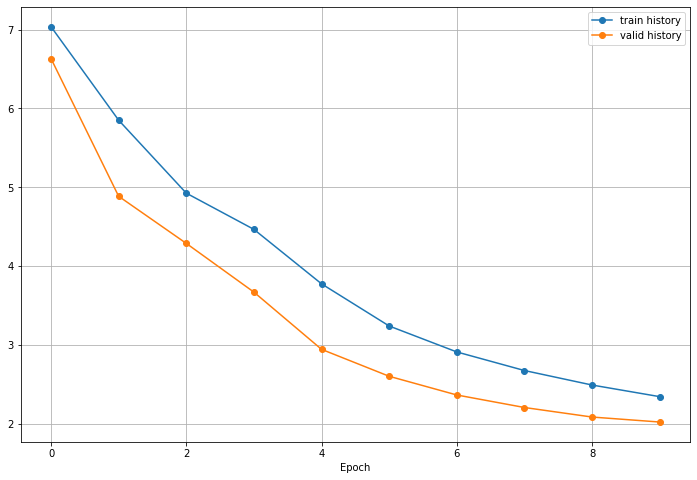

In [42]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

ax.plot(train_history, label='train history', marker = 'o')
ax.set_xlabel('Epoch')
ax.plot(val_history, label='valid history', marker = 'o')

plt.legend()
plt.grid()           
plt.show()